In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

In [2]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        cross_entropy = K.binary_crossentropy(y_true, y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return loss

In [3]:
data_dir = 'D:/Datasets/Date & Orange Fruit'
img_height, img_width = 224, 224
batch_size = 32
epochs = 30

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3324 images belonging to 5 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1423 images belonging to 5 classes.


In [7]:
from collections import Counter
print(Counter(train_generator.classes))

Counter({2: 1221, 3: 917, 4: 567, 0: 346, 1: 273})


In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/30


C:\Users\Amr Samir\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.1862 - loss: 0.0818 - val_accuracy: 0.3380 - val_loss: 0.0533 - learning_rate: 1.0000e-05
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.2715 - loss: 0.0682 - val_accuracy: 0.5952 - val_loss: 0.0474 - learning_rate: 1.0000e-05
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.3306 - loss: 0.0626 - val_accuracy: 0.5931 - val_loss: 0.0440 - learning_rate: 1.0000e-05
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.3603 - loss: 0.0595 - val_accuracy: 0.6149 - val_loss: 0.0415 - learning_rate: 1.0000e-05
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - accuracy: 0.3889 - loss: 0.0563 - val_accuracy: 0.6339 - val_loss: 0.0393 - learning_rate: 1.0000e-05
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 848s 8s/step - accuracy: 0.4661 - loss: 0.0503 - val_accuracy: 0.6346 - val_loss: 0.0379 - learning_rate: 1.0000e-05
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - accuracy: 0.48

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,529 (57.65 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 265,228 (1.01 MB)

In [17]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.5111 - loss: 0.0337
Validation Loss: 0.0245
Validation Accuracy: 74.98%


In [18]:
for layer in base_model.layers:
    layer.trainable = True

In [19]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

In [20]:
fine_tune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1807s 17s/step - accuracy: 0.7141 - loss: 0.0265 - val_accuracy: 0.8306 - val_loss: 0.0188 - learning_rate: 1.0000e-06
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1910s 18s/step - accuracy: 0.7968 - loss: 0.0204 - val_accuracy: 0.8313 - val_loss: 0.0159 - learning_rate: 1.0000e-06
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1908s 18s/step - accuracy: 0.8438 - loss: 0.0156 - val_accuracy: 0.8939 - val_loss: 0.0122 - learning_rate: 1.0000e-06
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1911s 18s/step - accuracy: 0.8885 - loss: 0.0129 - val_accuracy: 0.9241 - val_loss: 0.0100 - learning_rate: 1.0000e-06
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1899s 18s/step - accuracy: 0.8928 - loss: 0.0115 - val_accuracy: 0.9220 - val_loss: 0.0088 - learning_rate: 1.0000e-06
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1898s 18s/step - accuracy: 0.9122 - loss: 0.0093 - val_accuracy: 0.9375 - val_loss: 0.0076 - learning_rate: 1.0000e-06
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1890s 

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,541,905 (169.91 MB)

 Trainable params: 14,847,301 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,694,604 (113.28 MB)

In [23]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9780 - loss: 0.0031
Validation Loss: 0.0024
Validation Accuracy: 98.17%


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss =history.history['loss']
val_loss = history.history['val_loss']

<Figure size 640x480 with 0 Axes>

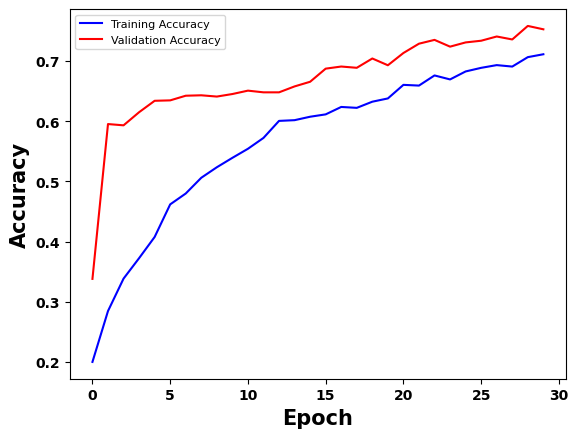

<Figure size 640x480 with 0 Axes>

In [25]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

<Figure size 640x480 with 0 Axes>

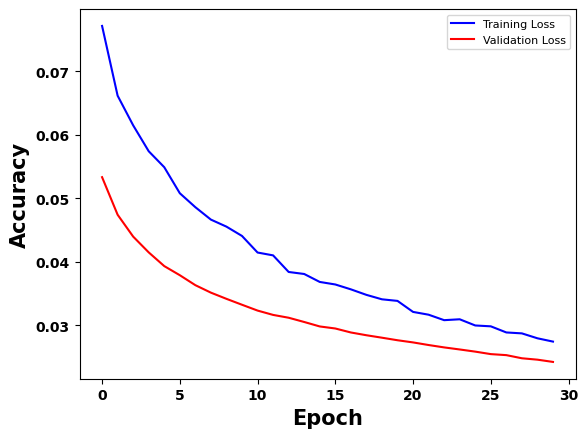

<Figure size 640x480 with 0 Axes>

In [26]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

In [27]:
Y_true = validation_generator.classes
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step


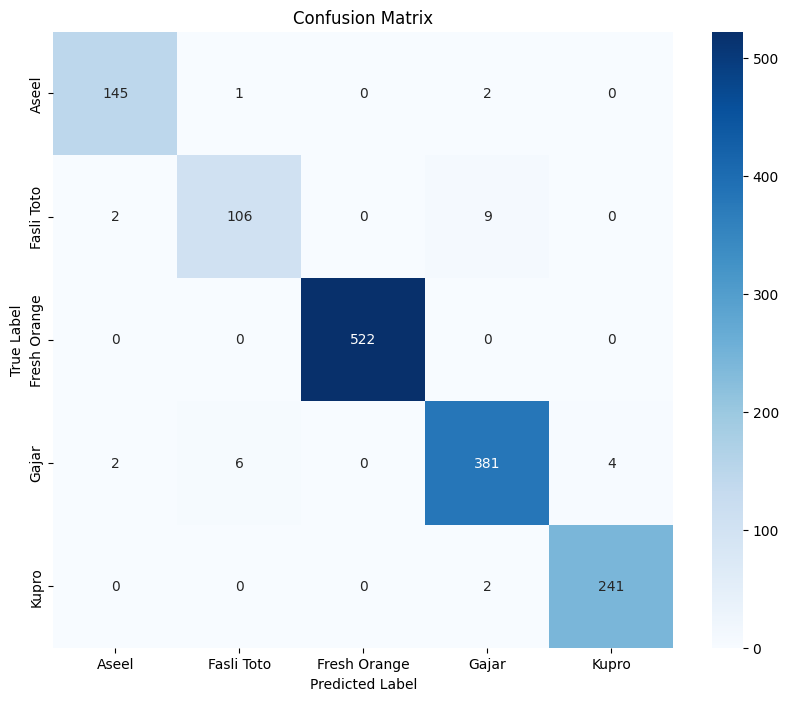

In [28]:
class_labels = list(validation_generator.class_indices.keys())
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       Aseel       0.97      0.98      0.98       148
  Fasli Toto       0.94      0.91      0.92       117
Fresh Orange       1.00      1.00      1.00       522
       Gajar       0.97      0.97      0.97       393
       Kupro       0.98      0.99      0.99       243

    accuracy                           0.98      1423
   macro avg       0.97      0.97      0.97      1423
weighted avg       0.98      0.98      0.98      1423



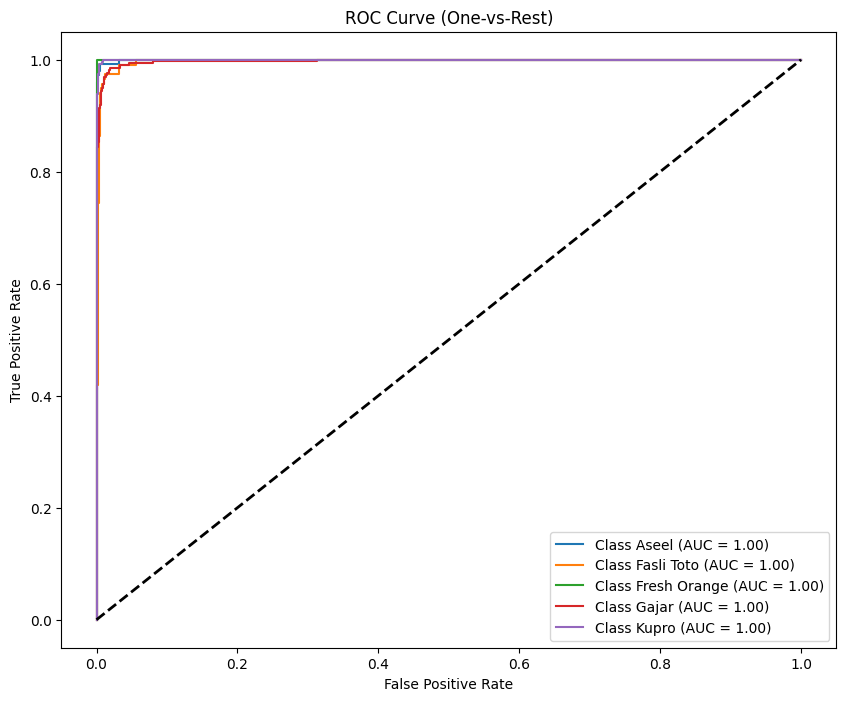

In [30]:
Y_true_binarized = label_binarize(Y_true, classes=np.arange(len(class_labels)))
fpr = {}
tpr = {}
roc_auc = {}
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [31]:
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"Accuracy for class {label}: {per_class_accuracy[i] * 100:.2f}%")

Accuracy for class Aseel: 97.97%
Accuracy for class Fasli Toto: 90.60%
Accuracy for class Fresh Orange: 100.00%
Accuracy for class Gajar: 96.95%
Accuracy for class Kupro: 99.18%


In [32]:
model.save('date_orange_classifier_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


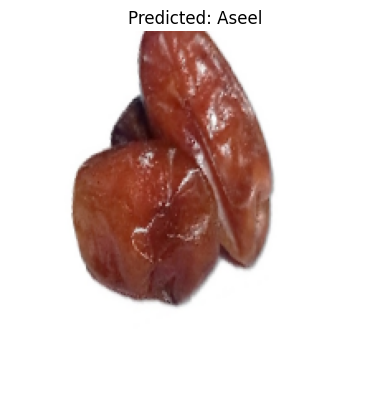

Predicted class: Aseel
Confidence scores: [0.5967104  0.11866757 0.10371608 0.16310364 0.01780224]


In [39]:
from tensorflow.keras.preprocessing import image 

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_image_path = "C:/Users/Amr Samir/Desktop/aseel1.jpg"

def preprocess_and_augment_image(image_path, img_height, img_width, datagen):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    augmented_images = datagen.flow(img_array, batch_size=1)
    augmented_img_array = next(augmented_images)[0]
    augmented_img_array = np.clip(augmented_img_array, 0, 255).astype('uint8')
    normalized_img_array = augmented_img_array / 255.0
    
    return augmented_img_array, normalized_img_array

img_height, img_width = 224, 224
augmented_img_array, normalized_img_array = preprocess_and_augment_image(
    test_image_path, img_height, img_width, train_datagen
)

predictions = model.predict(np.expand_dims(normalized_img_array, axis=0))
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = list(train_generator.class_indices.keys())[predicted_class_index]

plt.imshow(augmented_img_array)
plt.axis('off')
plt.title(f'Predicted: {predicted_class_label}')
plt.show()
print(f"Predicted class: {predicted_class_label}")
print(f"Confidence scores: {predictions[0]}")